# 📚 Beijing Air Quality Forecasting Notebook

This project is trying to predict air pollution levels using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network (RNN). The dataset used in this project is the Beijing PM2.5.

**Brief project introduction**

Air pollution is a critical issue affecting the health and well-being of people living worldwide. Making accurate predictions of pollution levels can assist governments, organizations and individuals take tangible precautions to prevent the impact of air pollution on public health.

This project uses LSTM networks to predict Beijing PM2.5 (particulate matter with a diameter of 2.5 micrometers or less) concentration levels, which are a key indicator of air pollution. LSTMs are well-suited for this task because they can learn and remember long-term dependencies in sequential data, such as time series.

In [34]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

In [2]:
# Mount Google Drive to access project dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the datasets
# Uploading train.csv and test.csv from Google Drive.

train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')

# **Exploring and explaining the dataset**

In this section, we explore the dataset with appropiate statistics and visualisations to understand more better. I will also explain the output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.

print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
# Showing the last rows of the data

train.tail()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
30671,30672,1.467633,0.946961,-2.088668,-0.415099,-0.069353,2.687490,2013-07-01 23:00:00,-0.690542,-0.732019,-0.522096,50.0
30672,30673,1.329064,0.864984,-2.186052,-0.379306,-0.069353,3.393779,2013-07-02 00:00:00,1.448138,-0.732019,-0.522096,41.0
30673,30674,1.259780,0.701029,-2.088668,-0.263130,-0.069353,4.100068,2013-07-02 01:00:00,1.448138,-0.732019,-0.522096,32.0
30674,30675,1.190496,0.701029,-2.088668,-0.146953,-0.069353,4.806358,2013-07-02 02:00:00,1.448138,-0.732019,-0.522096,19.0
30675,30676,1.190496,0.701029,-2.186052,-0.084366,-0.069353,-0.137667,2013-07-02 03:00:00,1.448138,-0.732019,-0.522096,18.0


In [6]:
# Showing the columns of the dataset

train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [7]:
# Summarize the train data

print("Train Data Summary:")
print(train.describe())

Train Data Summary:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.087278      1.0638

In [8]:
# Summarize the test data

print("Test Data Summary:")
print(test.describe())

Test Data Summary:
                 No          DEWP          TEMP          PRES           Iws  \
count  13148.000000  13148.000000  13148.000000  13148.000000  13148.000000   
mean   37250.500000      0.068667      0.146315     -0.031759     -0.071257   
std     3795.645004      1.010409      0.947697      0.978042      0.952125   
min    30677.000000     -2.897280     -2.086205     -2.478206     -0.468688   
25%    33963.750000     -0.749466     -0.692588     -0.920055     -0.441894   
50%    37250.500000      0.220515      0.209164     -0.043595     -0.388505   
75%    40537.250000      0.982643      0.946961      0.735481     -0.137955   
max    43824.000000      1.675486      2.422555      2.196248      9.327940   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  
count  13148.000000  13148.000000  13148.000000  13148.000000  13148.000000  
mean      -0.039645     -0.026255     -0.037780     -0.013608      0.058346  
std        0.756872      0.831803  

In [9]:
# Inspect the structure of the dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


**Handling missing values**


In [10]:
# Check for missing values
missing_values = train.isnull().sum()

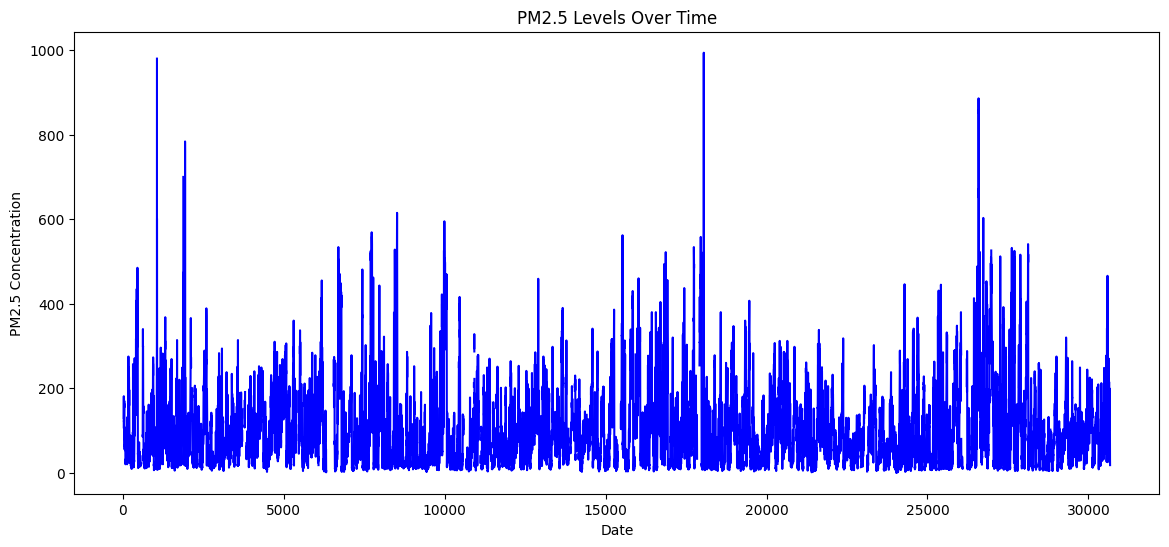

In [11]:
# Simple Line Plot
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['pm2.5'], color='blue')
plt.title("PM2.5 Levels Over Time")
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration")
plt.show()

# **Line Plot Explanation:**

- This above line plot shows how PM2.5 concentration levels change over time in the Beijing PM2.5 dataset. It helps identify trends, seasonal patterns, and sudden spikes or drops in pollution levels. By visualizing the data, we can better understand how air quality varies across different periods, detect any unusual events or data issues, and gain insights that are important for building an accurate time series forecasting model.

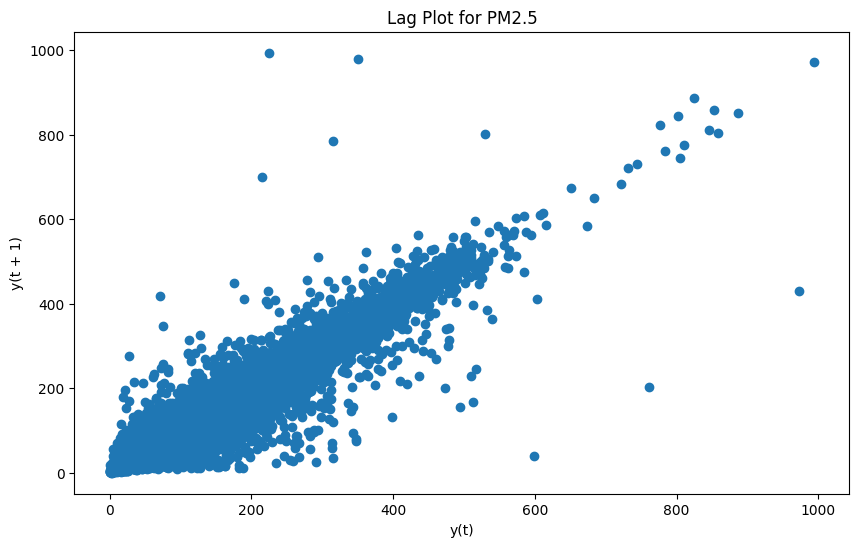

In [12]:
# Lagplot Visualization to detect autocorrelations

plt.figure(figsize=(10, 6))
lag_plot(train['pm2.5'], lag=1)
plt.title("Lag Plot for PM2.5")
plt.show()

# **Lag Plot Explanation**

This lag plot visualizes the relationship between PM2.5 values and their previous values (lag = 1) to detect **autocorrelation** in the data. If the points form a clear pattern, such as a straight line or cluster, it indicates that current PM2.5 levels are strongly related to past values. This is important for time series forecasting because it shows whether past data can help predict future PM2.5 levels, which is a key assumption for models like LSTM.

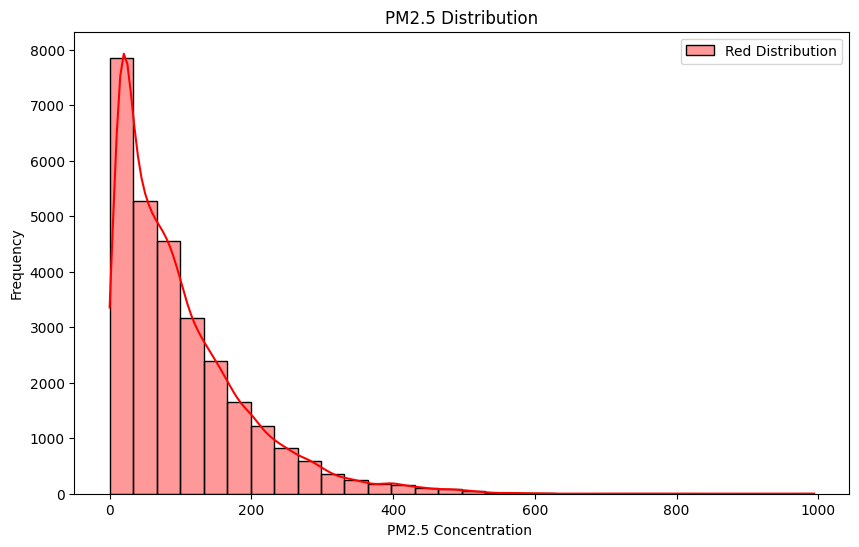

In [13]:
# Histogram of PM2.5 concentration

plt.figure(figsize=(10, 6))
sns.histplot(train['pm2.5'], kde=True, bins=30, color='red', label='Red Distribution', alpha=0.4)

plt.title("PM2.5 Distribution")
plt.xlabel("PM2.5 Concentration ")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# **Histogram Explanation**

- This histogram shows the distribution of PM2.5 concentration levels in the dataset. It helps us understand how frequently different PM2.5 values occur and reveals the data's shape, such as whether it's skewed, has outliers, or follows a normal distribution. The added KDE (Kernel Density Estimate) curve provides a smooth outline of the data’s distribution. This visualization is important because it highlights patterns like extreme pollution levels, helps detect outliers, and informs decisions on data preprocessing, such as normalization or handling skewed data, to improve model performance.

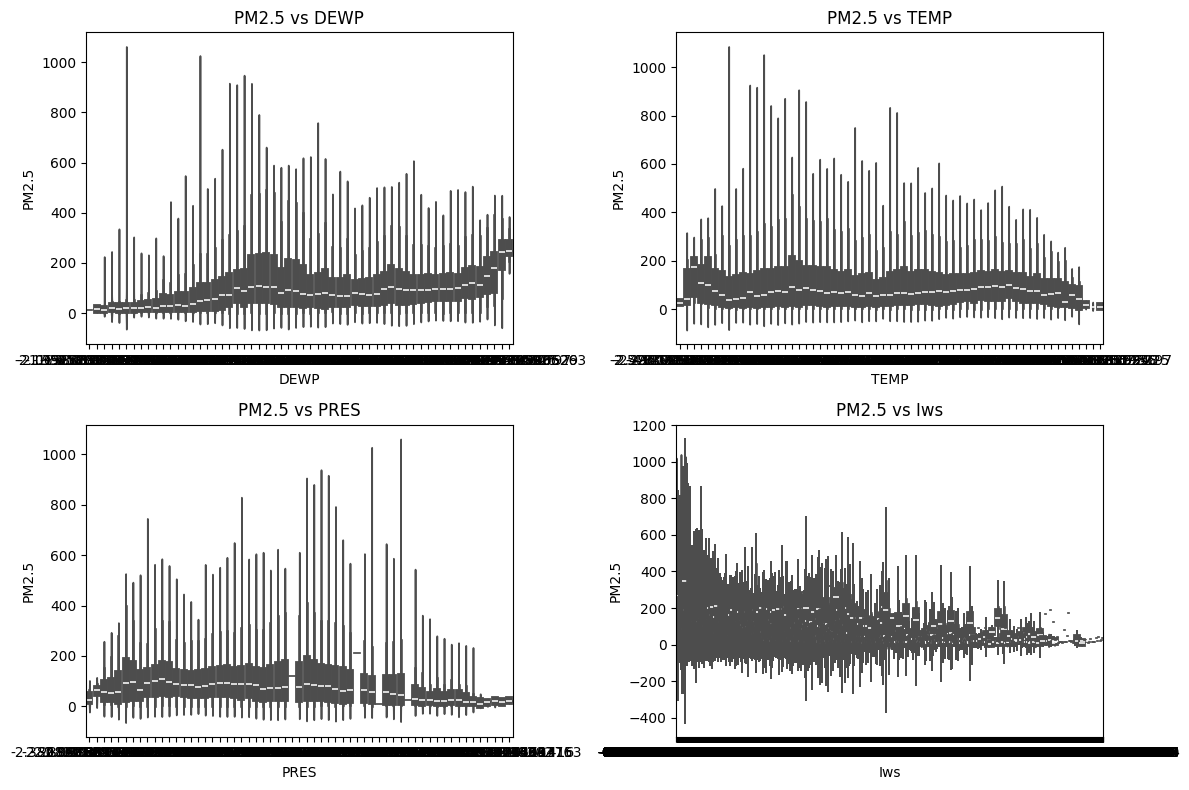

In [44]:
# Violin Plot

# Plotting PM2.5 against 'DEWP', 'TEMP', 'PRES', and 'Iws'
features_to_plot = ['DEWP', 'TEMP', 'PRES', 'Iws']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(x=train[feature], y=train['pm2.5'], color='blue')
    plt.title(f"PM2.5 vs {feature}")
    plt.xlabel(feature)
    plt.ylabel('PM2.5')
plt.tight_layout()
plt.show()

# **Violin Plot Explanation**

- The above violin plot visualizes the distribution of PM2.5 levels in relation to different features from the dataset. It combines a box plot and a KDE (Kernel Density Estimate) to show both the spread and density of the data. The width of each "violin" represents the frequency of PM2.5 values at different levels of the corresponding feature. This helps identify patterns, such as how PM2.5 concentration varies with specific features, detect outliers, and understand data symmetry or skewness. Such insights are useful for feature selection and improving model performance.

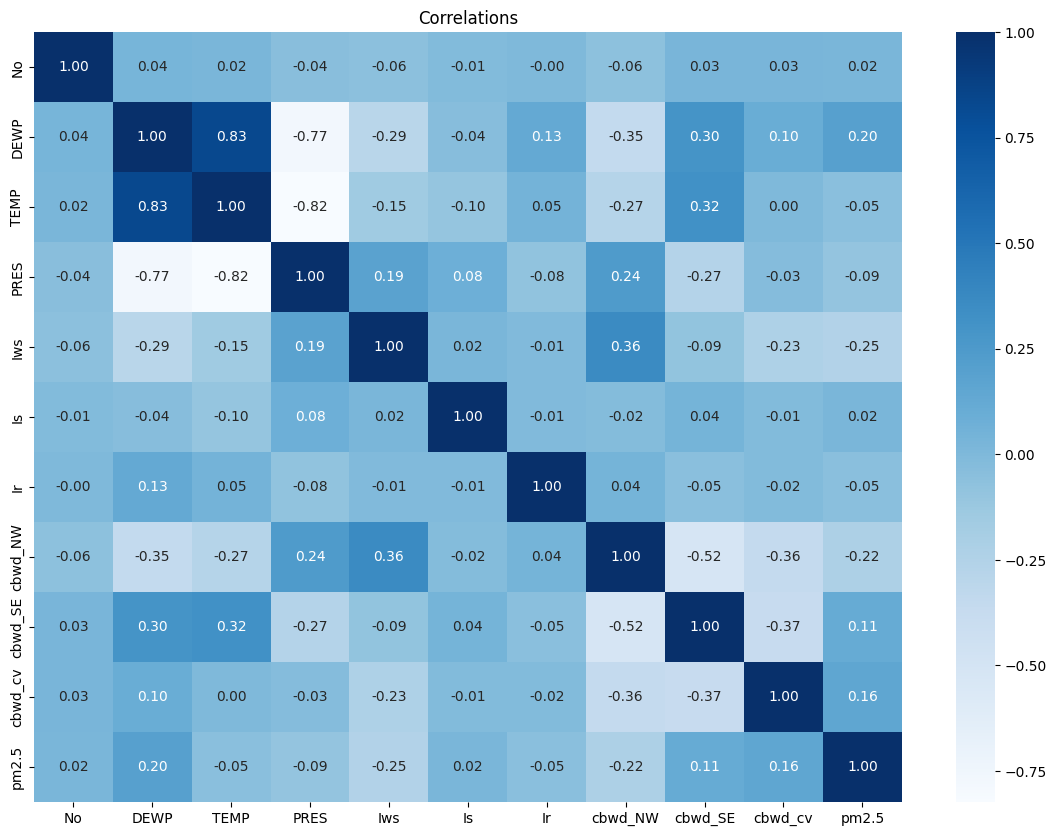

In [40]:
# Correlations heatmap
train = pd.get_dummies(train)

plt.figure(figsize=(14, 10))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Correlations")
plt.show()

# **The Correlation Map Explanation**

- The correlation heatmap shows the relationships between different features in the dataset, with color intensity representing the strength of the correlation. Values range from -1 (strong negative correlation) to 1 (strong positive correlation), while values near 0 indicate little to no correlation. The heatmap helps identify which features are most strongly related to PM2.5 levels, guiding feature selection for the model. It also reveals multicollinearity (when features are highly correlated with each other), which can negatively affect model performance and may need to be addressed during preprocessing.

# **Preparing data for training**

In [14]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

In [16]:
# Fill missing values with bfill and fill

train['pm2.5'] = train['pm2.5'].bfill()
train['pm2.5'] = train['pm2.5'].ffill()

In [17]:
# prep data to train

X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']
X_train = np.expand_dims(X_train, axis=1)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
# First Given Example

# define model
model = Sequential([
    LSTM(4, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()

# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16
)

# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")


In [20]:
# Experiment 1: This is LSTM model  for second Model with  2 LSTM Layers with simple 64 and 32 neurons. It also has 25 epochs.

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile the model with a tuned optimizer with tuned learning rate and RMSE metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=64,
    verbose=1
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - lambda: 121.2456 - loss: 15304.9736
Epoch 2/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - lambda: 83.2922 - loss: 7139.8198
Epoch 3/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - lambda: 80.5099 - loss: 6648.5698
Epoch 4/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 77.5308 - loss: 6202.0161
Epoch 5/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lambda: 76.8537 - loss: 6122.8696
Epoch 6/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - lambda: 76.1317 - loss: 5960.1089
Epoch 7/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - lambda: 76.9802 - loss: 6131.1655
Epoch 8/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 75.9656 - loss: 5921.0034
Epoch 9/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - lambda: 76.5058 - loss: 5988.1440
Epoch 10/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - lambda: 74.9833 - loss: 5781.0508
Epoch 11/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - lambda: 76.1050 - loss: 5952.7759
Epoch 12/25
480/480 ━━━━━━━━━━━━━━━━━━━

In [23]:
# Experiment 2: This is LSTM model  for second Model with  3 LSTM Layers with simple 128, 64 and 32 neurons. It also has 75 epochs. It also has Batch Normalization to accelerate training.

model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])

# Compile the model with tuned optimizer and RMSE
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)


# The model summary
model.summary()

# Train epochs
history = model.fit(
    X_train, y_train,
    epochs=75,
    batch_size=128,
    verbose=1,
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,177 (602.25 KB)

 Trainable params: 153,665 (600.25 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - lambda: 134.8725 - loss: 18344.8477
Epoch 2/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - lambda: 125.4378 - loss: 15847.5176
Epoch 3/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - lambda: 119.6011 - loss: 14444.0117
Epoch 4/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - lambda: 111.5484 - loss: 12601.5107
Epoch 5/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - lambda: 102.9119 - loss: 10703.5566
Epoch 6/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - lambda: 95.3096 - loss: 9193.1260
Epoch 7/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - lambda: 87.6549 - loss: 7803.3774
Epoch 8/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - lambda: 81.7193 - loss: 6793.7944
Epoch 9/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - lambda: 78.2947 - loss: 6253.6191
Epoch 10/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - lambda: 75.6779 - loss: 5850.9053
Epoch 11/75
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - lambda: 74.9545 - loss: 5733.2568
Epoch 12

In [26]:
# Experiment 3: This is LSTM model with l1 regularization and Batch Normalization with 100 epochs.

model = Sequential([
    LSTM(128,
         activation='relu',
         return_sequences=True,
         input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_regularizer=l1(0.01)),  # L1 regularization
    BatchNormalization(),

    LSTM(64,
         activation='relu',
         return_sequences=False,
         kernel_regularizer=l1(0.01)),  # L1 regularization
    BatchNormalization(),

    Dense(1, kernel_regularizer=l1(0.01))
])

# Compile the model with RMSE and tuned optimizer.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Print the model summary
model.summary()

# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    verbose=1,
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,897 (472.25 KB)

 Trainable params: 120,513 (470.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - lambda: 130.2754 - loss: 17275.6367
Epoch 2/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - lambda: 116.8333 - loss: 13910.1338
Epoch 3/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - lambda: 100.3810 - loss: 10290.7451
Epoch 4/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - lambda: 84.3662 - loss: 7374.3442
Epoch 5/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - lambda: 74.1349 - loss: 5689.1938
Epoch 6/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - lambda: 72.0491 - loss: 5384.9912
Epoch 7/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - lambda: 71.3676 - loss: 5262.4409
Epoch 8/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - lambda: 72.7425 - loss: 5489.1890
Epoch 9/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - lambda: 71.5848 - loss: 5291.1406
Epoch 10/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - lambda: 70.4470 - loss: 5114.4395
Epoch 11/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - lambda: 71.6414 - loss: 5294.2979
Epoch 

# **Final Robust Experiment**

- In this last experiment, I focused on designing LSTM architecture fthat incorporates regularization techniques to reduce overfitting and improve generalization.


- The model consists of four LSTM layers with decreasing units (128, 64, 32, 16) and includes dropout layers (with rates of 0.6 and 0.5) after each LSTM layer to prevent overfitting. Batch normalization is applied after each LSTM layer to stabilize the training process and improve convergence.

- The model is compiled with the Adam optimizer and a reduced learning rate of 0.0008 for better stability, and the Root Mean Squared Error (RMSE) is used as the evaluation metric. During training, 20% of the data is used for validation, and the model is trained for 50 epochs with a batch size of 32.

- The final training loss (MSE) is plotted alongside the loss during training to evaluate model performance.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 1, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 1, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 1, 16)               │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 1, 16)               │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1, 1)                │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,593 (533.57 KB)

 Trainable params: 136,113 (531.69 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - lambda: 127.9611 - loss: 16784.0156 - val_lambda: 125.1098 - val_loss: 23341.4316
Epoch 2/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - lambda: 123.1147 - loss: 15537.5820 - val_lambda: 112.2744 - val_loss: 19276.6621
Epoch 3/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - lambda: 112.1124 - loss: 12238.6895 - val_lambda: 97.0462 - val_loss: 14194.2686
Epoch 4/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - lambda: 102.9146 - loss: 9542.5859 - val_lambda: 88.0513 - val_loss: 11094.6816
Epoch 5/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - lambda: 96.9709 - loss: 7645.2769 - val_lambda: 83.7088 - val_loss: 8802.6582
Epoch 6/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - lambda: 93.7974 - loss: 6487.2876 - val_lambda: 83.8123 - val_loss: 8041.8872
Epoch 7/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - lambda: 94.4826 - loss: 6187.2070 - val_lambda: 83.9698 - val_loss: 7612.3545
Epoch 8/100
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s

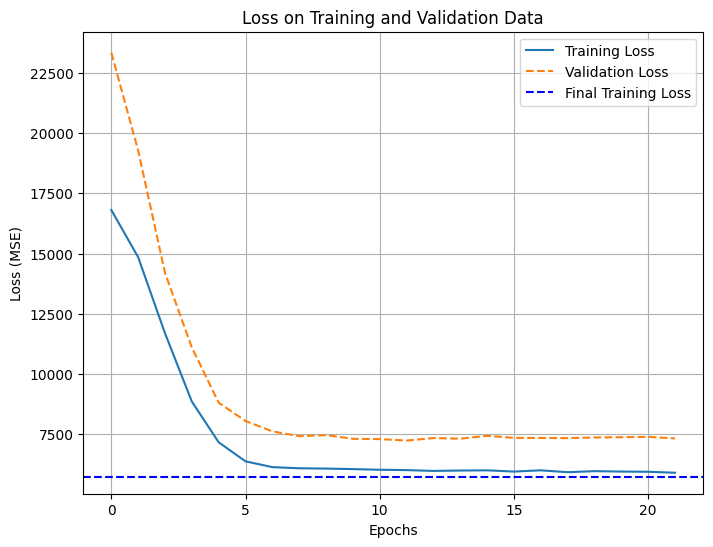

Final Training Loss (MSE): 5696.075177337186


In [32]:
# Define the model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.7),  # Increased dropout to further reduce overfitting
    BatchNormalization(),  # Batch normalization for stable training

    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.6),  # Increased dropout to improve generalization
    BatchNormalization(),

    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.6),  # Increased dropout to improve generalization
    BatchNormalization(),

    LSTM(16, activation='relu', return_sequences=True),
    Dropout(0.6),  # Increased dropout to improve generalization
    BatchNormalization(),

    Dense(1)  # Final layer for regression
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate for stability
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,  # Increased epochs for more training time
    batch_size=32,  # Adjusted batch size to improve model generalization
    validation_split=0.2,  # Adding validation split for better model evaluation
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]  # Early stopping to prevent overfitting
)

# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')  # Validation loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Training Loss')  # Final training loss
plt.title('Loss on Training and Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [38]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/successful-submission.csv', index=False)



411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
